In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from segysak.segy import segy_loader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import pickle
import segyio

warnings.filterwarnings(action='ignore')

In [4]:
def norm_data(X, x_min, x_max):
    return (X - x_min) / (x_max - x_min)

def obj_to_pixel_df(cube_str, cube_sgy, obj, width, height, index_label, derivative='default'):

    dataset = pd.DataFrame()

    if width % 2 > 0:
        width_coef = 1
    else:
        width_coef = 0
    
    if height % 2 > 0:
        height_coef = 1
    else:
        height_coef = 0

    half_width = int(round(width / 2 - 0.5, 0))
    half_height = int(round(height / 2 - 0.5, 0))
    
    count = 0
    for click in obj:
        iline_number = click['inline']
        xline_number = click['crossline']

        x = click['x']
        y = click['y']

        if iline_number != None:
            if cube_str == 'similarity':
                img = cube_sgy.isel(iline=iline_number).data.T.to_numpy()[x - half_width : x + half_width + width_coef, y - half_height : y + half_height + height_coef]
            else:
                img = cube_sgy.iline[iline_number][x - half_width : x + half_width + width_coef, y - half_height : y + half_height + height_coef].T
        else:
            if cube_str == 'similarity':
                img = cube_sgy.isel(xline=xline_number).data.T.to_numpy()[x - half_width : x + half_width + width_coef, y - half_height : y + half_height + height_coef]
            else:
                img = cube_sgy.xline[xline_number][x - half_width : x + half_width + width_coef, y - half_height : y + half_height + height_coef].T

        if derivative == 'horizontal':
            img = np.diff(img) / 25
        elif derivative == 'vertical':
            img = np.diff(img.T).T / 0.004

        pixels = img.reshape(-1,1)

        if derivative == 'default':
            if len(pixels) == int(width * height):
                pixels = norm_data(pixels, np.min(pixels), np.max(pixels))
                dataset[f'{index_label}{count}'] = [pixel[0] for pixel in pixels.tolist()]
        else:
            if len(pixels) == int(width * height - width):
                pixels = norm_data(pixels, np.min(pixels), np.max(pixels))
                dataset[f'{index_label}{count}'] = [pixel[0] for pixel in pixels.tolist()]

        count += 1

    dataset = dataset.T
    #dataset.index = [f'{index_label}{i}' for i in range(len(dataset))]

    if index_label == 'Fault':
        dataset['y'] = [1 for i in range(len(dataset))]

    elif index_label == 'Non_Fault':
        dataset['y'] = [0 for i in range(len(dataset))]

    return dataset

In [64]:
amplitude_cube_path = r'C:\Users\jpgom\Documents\Jão\VS_Code\IC\Seismic_data_w_null.sgy'
#similarity_cube_path = r'C:\Users\jpgom\Documents\Jão\VS_Code\IC\F3_Similaridade_Full (455).sgy'

#default_cube_path = '/home/gaia/jpedro/Seismic_data_w_null.sgy'
#similarity_cube_path = '/home/gaia/jpedro/F3_Similaridade_Full (455).sgy'

amplitude_cube = segyio.open(amplitude_cube_path)
#similarity_cube = segy_loader(similarity_cube_path, iline=189, xline=193, cdpx=181, cdpy=185)

In [7]:
file = open(r'C:\Users\jpgom\Documents\Jão\git\facies_selector\Fault.obj', 'rb')
#file = open('/home/gaia/jpedro/git/facies_selector/Fault.obj', 'rb')
fault_obj = pickle.load(file)
file.close()

file = open(r'C:\Users\jpgom\Documents\Jão\git\facies_selector\Non_Fault.obj', 'rb')
#file = open('/home/gaia/jpedro/git/facies_selector/Fault.obj', 'rb')
non_fault_obj = pickle.load(file)
file.close()

In [65]:
width = 21
height = 21

X_fault_amplitude = obj_to_pixel_df('default', amplitude_cube, fault_obj, width, height, 'Fault')
X_non_fault_amplitude = obj_to_pixel_df('default', amplitude_cube, non_fault_obj, width, height, 'Non_Fault')

#X_fault_similarity = obj_to_pixel_df('similarity', similarity_cube, fault_obj, width, height, 'Fault')
#X_non_fault_similarity = obj_to_pixel_df('similarity', similarity_cube, non_fault_obj, width, height, 'Non_Fault')

KeyboardInterrupt: 

In [55]:
dataset_amplitude = pd.concat([X_fault_amplitude, X_non_fault_amplitude])
#dataset_similarity = pd.concat([X_fault_similarity, X_non_fault_similarity]).iloc[:,:-1]

dataset_amplitude.rename(columns={i : f'Pixel{i}_D' for i in range(len(dataset_amplitude.columns) - 1)}, inplace=True)
#dataset_similarity.rename(columns={i : f'Pixel{i}_S' for i in range(len(dataset_similarity.columns))}, inplace=True)

#dataset = pd.concat([dataset_amplitude, dataset_similarity], axis=1)

#dataset = dataset.dropna()
dataset = dataset_amplitude.dropna()

dataset = dataset.sample(frac=1)

X = dataset[dataset.columns.drop('y')]
y = dataset['y']

In [10]:
#X.tail(5)

In [11]:
# index = -2
# img = np.array(X.iloc[index, width * height :]).reshape(width, height)
# plt.imshow(img, cmap='gray_r', aspect='auto', interpolation='spline36')

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=9, train_size=0.70)

In [13]:
# clf = LogisticRegression(penalty='none', 
#                          solver='saga',
#                          n_jobs=-1,
#                          multi_class='multinomial').fit(X_train, y_train)

# clf.coef_.shape

# y_pred_test = clf.predict(X_test)
# acc_test = accuracy_score(y_test, y_pred_test)

# y_pred_train = clf.predict(X_train)
# acc_train = accuracy_score(y_train, y_pred_train)

# print(f'Model Accuracy (Train): {round(acc_train * 100, 2)}% | Model Accuracy (Test): {round(acc_test * 100, 2)}%')

In [14]:
# plot_confusion_matrix(clf, X_test, y_test, display_labels=['Non-Fault', 'Fault'])

In [15]:
#print(classification_report(y_test,y_pred_test))

In [16]:
from sklearn.neighbors import KNeighborsClassifier

In [57]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train,y_train)

y_pred_test = knn.predict(X_test)
acc_test = accuracy_score(y_test, y_pred_test)

y_pred_train = knn.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)

print(f'Model Accuracy (Train): {round(acc_train * 100, 2)}% | Model Accuracy (Test): {round(acc_test * 100, 2)}%')

Model Accuracy (Train): 89.32% | Model Accuracy (Test): 83.33%


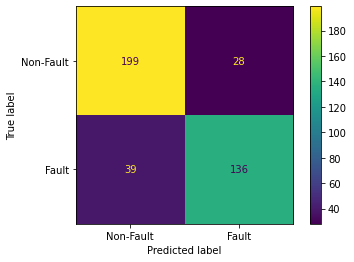

In [58]:
plot_confusion_matrix(knn, X_test, y_test, display_labels=['Non-Fault', 'Fault'])

In [36]:
#print(classification_report(y_test,y_pred_test))

In [59]:
acc_k_train = []
acc_k_test = []

for k in range(3,51,2):
   knn = KNeighborsClassifier(n_neighbors=k)
   knn.fit(X_train,y_train)

   y_pred = knn.predict(X_test)
   acc = accuracy_score(y_test, y_pred)

   y_pred_train = knn.predict(X_train)
   acc_train = accuracy_score(y_train, y_pred_train)

   acc_k_train += [acc_train]
   acc_k_test += [acc]


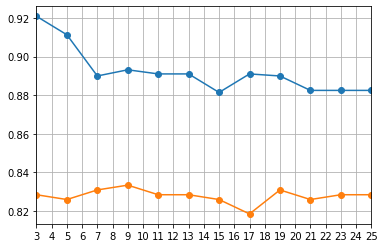

In [60]:
plt.plot(range(3,51,2), acc_k_train,marker='o')
plt.plot(range(3,51,2), acc_k_test,marker='o')

plt.xticks(np.arange(0,100))
plt.xlim(3,25)
plt.grid()

In [ ]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

In [ ]:
# pca = PCA()

In [ ]:
# scaler = StandardScaler()

# pca.fit(scaler.fit_transform(X_train[:17*17]))

In [ ]:
# X_pca = pca.transform(scaler.fit_transform(X_train[:17*17]))

In [ ]:
# plt.imshow(X_train.iloc[15].values[:17*17].reshape(17,17),interpolation='spline36',cmap='seismic')

In [ ]:
# plt.imshow(X_pca[15][:100].reshape(10,10),interpolation='spline36',cmap='seismic')

In [ ]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [ ]:
# np.cumsum(pca.explained_variance_ratio_)[100]

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [61]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=11)
dt.fit(X_train, y_train)

y_pred_test = dt.predict(X_test)
acc_test = accuracy_score(y_test, y_pred_test)

y_pred_train = dt.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)

print(f'Model Accuracy (Train): {round(acc_train * 100, 2)}% | Model Accuracy (Test): {round(acc_test * 100, 2)}%')

Model Accuracy (Train): 85.04% | Model Accuracy (Test): 66.67%


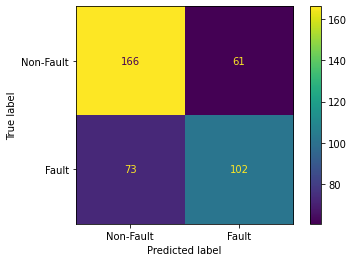

In [62]:
plot_confusion_matrix(dt, X_test, y_test, display_labels=['Non-Fault', 'Fault'])

In [44]:
#print(classification_report(y_test, y_pred_test))

In [45]:
# plt.figure(figsize=(60,60))
# plot_tree(dt, filled=True, rounded=True, class_names=['Non-Fault', 'Fault'], feature_names=X_train.columns)

KeyboardInterrupt: 

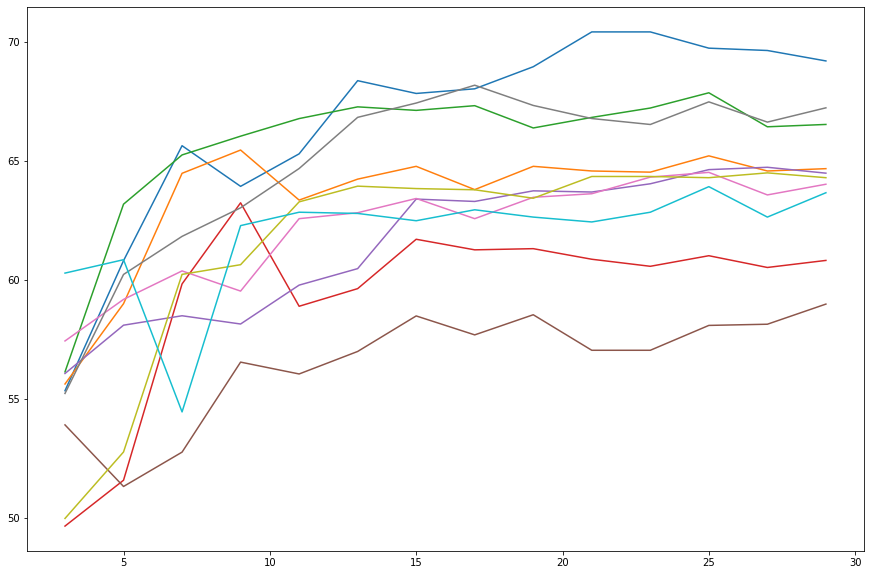

In [68]:
depth_range = range(3, 31, 2)
width_range = range(11, 32, 2)

plt.figure(figsize=(15,10))

for width in width_range:
    height = width

    X_fault = obj_to_pixel_df('amplitude', amplitude_cube, fault_obj, width, height, 'Fault')
    X_non_fault = obj_to_pixel_df('amplitude', amplitude_cube, non_fault_obj, width, height, 'Non_Fault')
    
    dataset = pd.concat([X_fault, X_non_fault])

    dataset.rename(columns={i : f'Pixel{i}' for i in range(len(dataset.columns) - 1)}, inplace=True)

    dataset = dataset.sample(frac=1)

    X = dataset.iloc[:,:-1]
    y = dataset['y']

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

    acc_test_list = []
    acc_train_list = []
    for depth in depth_range:
        acc_test_mean_list = []
        acc_train_mean_list = []

        for i in range(5):
            model = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            acc_test = accuracy_score(y_test, y_pred)

            y_pred_train = model.predict(X_train)
            acc_train = accuracy_score(y_train, y_pred_train)

            acc_test_mean_list += [acc_test * 100]
            acc_train_mean_list += [acc_train * 100]

        acc_test_list += [np.mean(acc_test_mean_list)]
        acc_train_list += [np.mean(acc_train_mean_list)]

    plt.plot(depth_range, acc_test_list, label=f'Teste | w_h: {width} x {height}')
    #plt.plot(depth_range, acc_train_list, label=f'Treino | w_h: {width} x {height}')

plt.xlabel('Profundidade Máxima')
plt.ylabel('Precisão (%)')
plt.legend()

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

y_pred_test = rfc.predict(X_test)
acc_test = accuracy_score(y_test, y_pred_test)

y_pred_train = rfc.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)

print(f'Model Accuracy (Train): {round(acc_train * 100, 2)}% | Model Accuracy (Test): {round(acc_test * 100, 2)}%')

Model Accuracy (Train): 100.0% | Model Accuracy (Test): 78.33%


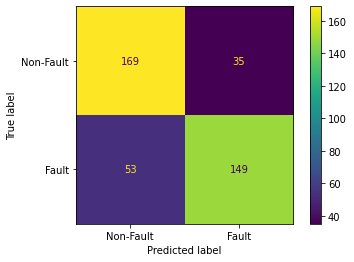

In [49]:
plot_confusion_matrix(rfc, X_test, y_test, display_labels=['Non-Fault', 'Fault'])

VARREDURA

In [50]:
iline_number = 300
width, height = 15, 15

iline_amplitude_array = default_cube.iline[iline_number].T
#iline_similarity_array = similarity_cube.isel(iline=iline_number).data.T.to_numpy()

mask_array = np.zeros(iline_amplitude_array.shape) * np.nan

for i, row in enumerate(iline_amplitude_array):
        
    if i > 0 and X_to_predict.shape != (1, width * height):
        pass
        
    for j, col in enumerate(row):
            
        window_amplitude_array = iline_amplitude_array[i : i + height, j : j + width]
        window_amplitude_array = norm_data(window_amplitude_array, np.min(window_amplitude_array), np.max(window_amplitude_array))

        #window_similarity_array = iline_amplitude_array[i : i + height, j : j + width]
        #window_similarity_array = norm_data(window_similarity_array, np.min(window_similarity_array), np.max(window_similarity_array))

        window_center_coord = (i + int(height / 2), j + int(height / 2))
        
        amplitude_pixels = window_amplitude_array.reshape(1,-1)
        #similarity_pixels = window_similarity_array.reshape(1,-1)
        
        X_to_predict = amplitude_pixels
        
        if X_to_predict.shape != (1, width * height):
            pass
        else:
            predicted_value = knn.predict(X_to_predict)[0]

            mask_array[i][j] = predicted_value

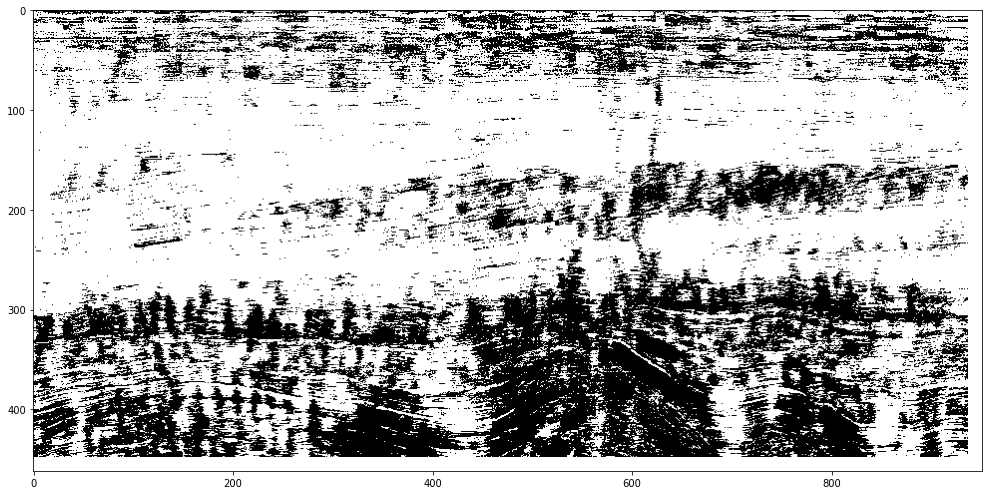

In [53]:
plt.figure(figsize=(17,10))
plt.imshow(mask_array, cmap='gray_r')